In [1]:
import matplotlib as mpl

# This line allows mpl to run with no DISPLAY defined
mpl.use('Agg')

import pandas as pd
import numpy as np
import os
from keras.layers import Reshape, Flatten, LeakyReLU, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras_adversarial.image_grid_callback import ImageGridCallback
from keras_adversarial import AdversarialModel, simple_gan, gan_targets
from keras_adversarial import normal_latent_sampling, AdversarialOptimizerSimultaneous
from keras_adversarial.legacy import l1l2, Dense, fit
import keras.backend as K
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
def mnist_process(x):
    x = x.astype(np.float32) / 255.0
    return x


def mnist_data():
    (xtrain, ytrain), (xtest, ytest) = mnist.load_data()
    return mnist_process(xtrain), mnist_process(xtest)

In [3]:
def model_generator(latent_dim, input_shape, hidden_dim=1024, reg=lambda: l1l2(1e-5, 1e-5)):
    return Sequential([
        Dense(int(hidden_dim / 4), name="generator_h1", input_dim=latent_dim, W_regularizer=reg()),
        LeakyReLU(0.2),
        Dense(int(hidden_dim / 2), name="generator_h2", W_regularizer=reg()),
        LeakyReLU(0.2),
        Dense(hidden_dim, name="generator_h3", W_regularizer=reg()),
        LeakyReLU(0.2),
        Dense(np.prod(input_shape), name="generator_x_flat", W_regularizer=reg()),
        Activation('sigmoid'),
        Reshape(input_shape, name="generator_x")],
        name="generator")

In [4]:
def model_discriminator(input_shape, hidden_dim=1024, reg=lambda: l1l2(1e-5, 1e-5), output_activation="sigmoid"):
    return Sequential([
        Flatten(name="discriminator_flatten", input_shape=input_shape),
        Dense(hidden_dim, name="discriminator_h1", W_regularizer=reg()),
        LeakyReLU(0.2),
        Dense(int(hidden_dim / 2), name="discriminator_h2", W_regularizer=reg()),
        LeakyReLU(0.2),
        Dense(int(hidden_dim / 4), name="discriminator_h3", W_regularizer=reg()),
        LeakyReLU(0.2),
        Dense(1, name="discriminator_y", W_regularizer=reg()),
        Activation(output_activation)],
        name="discriminator")

In [5]:
# z \in R^100
latent_dim = 100

# x \in R^{28x28}
input_shape = (28, 28)

In [6]:
# generator (z -> x)
generator = model_generator(latent_dim, input_shape)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_h1 (Dense)         (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
generator_h2 (Dense)         (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
generator_h3 (Dense)         (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
generator_x_flat (Dense)     (None, 784)               803600    
__________

In [7]:
# discriminator (x -> y)
discriminator = model_discriminator(input_shape)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_flatten (Flatt (None, 784)               0         
_________________________________________________________________
discriminator_h1 (Dense)     (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
discriminator_h2 (Dense)     (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
discriminator_h3 (Dense)     (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
__________

In [14]:
csvpath = os.path.join("output/gan", "history.csv")
if os.path.exists(csvpath):
    print("Already exists: {}".format(csvpath))

In [15]:
print("Training: {}".format(csvpath))

Training: output/gan/history.csv


In [16]:
# gan (x - > yfake, yreal), z generated on GPU
gan = simple_gan(generator, discriminator, normal_latent_sampling((latent_dim,)))
gan.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
discriminator_flatten_input (Inp (None, 28, 28)        0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 100)           0                                            
____________________________________________________________________________________________________
gan (Model)                      [(None, 1), (None, 1) 2946577                                      
____________________________________________________________________________________________________
yfake (Activation)               (None, 1)             0                                            
___________________________________________________________________________________________

In [19]:
# build adversarial model
model = AdversarialModel(base_model=gan,
                         player_params=[generator.trainable_weights, discriminator.trainable_weights],
                         player_names=["generator", "discriminator"])

In [26]:
adversarial_optimizer = AdversarialOptimizerSimultaneous()
opt_g = Adam(1e-4, decay=1e-4)
opt_d = Adam(1e-3, decay=1e-4)
loss = 'binary_crossentropy' # binary classification task: REAL or FAKE. Therefore binary cross entropy loss.

model.adversarial_compile(adversarial_optimizer=adversarial_optimizer,
                          player_optimizers=[opt_g, opt_d],
                          loss=loss)

In [28]:
# create callback to generate images
zsamples = np.random.normal(size=(10 * 10, latent_dim))

def generator_sampler():
    return generator.predict(zsamples).reshape((10, 10, 28, 28))

generator_cb = ImageGridCallback(os.path.join("output/gan", "epoch-{:03d}.png"), generator_sampler)

In [34]:
# train model
# GPU version: https://raw.githubusercontent.com/bstriner/keras-adversarial/master/examples/example_gan.py
# of course one epoch is too small. Put at least 100 epochs and if you run on CPU, be patient!
# also we have a mode collapse with this simple model:
# The generator understands that outputting 1 is the best way to fake the discriminator.
# So I guess most of the trainings do not work well because the generated numbers will be almost always 1.
nb_epoch = 1 # run all this code on a GPU and it will be much faster! I have 117 seconds on my CPU and 22 seconds on my GPU.
xtrain, xtest = mnist_data()
y = gan_targets(xtrain.shape[0])
ytest = gan_targets(xtest.shape[0])
callbacks = [generator_cb]
if K.backend() == "tensorflow":
    callbacks.append(
        TensorBoard(log_dir=os.path.join("output/gan", 'logs'), histogram_freq=0, write_graph=True, write_images=True))
history = fit(model, x=xtrain, y=y, validation_data=(xtest, ytest), callbacks=callbacks, nb_epoch=nb_epoch,
              batch_size=32)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 176s - loss: 18.7926 - generator_loss: 16.3468 - generator_yfake_loss: 3.6518 - generator_yreal_loss: 10.4823 - discriminator_loss: 2.4459 - discriminator_yfake_loss: 0.0850 - discriminator_yreal_loss: 0.1481 - val_loss: 19.5150 - val_generator_loss: 17.0469 - val_generator_yfake_loss: 2.7409 - val_generator_yreal_loss: 12.1702 - val_discriminator_loss: 2.4681 - val_discriminator_yfake_loss: 0.1996 - val_discriminator_yreal_loss: 0.1327


In [37]:
# save history to CSV
df = pd.DataFrame(history.history)
df.to_csv(csvpath)

# save models
generator.save(os.path.join("output/gan", "generator.h5"))
discriminator.save(os.path.join("output/gan", "discriminator.h5"))

# h5 files can be used to generate pictures later. Only the generator is important here.
# We can discard the discriminator because our main purpose is to generate nice pictures.

# Code to load a model from h5 files:
# from keras.models import load_model
# model = load_model('model.h5')

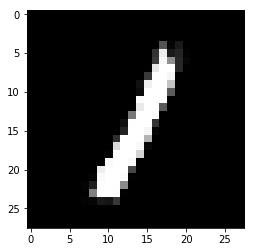

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
fake_image_from_generator = generator_sampler()[0][2] # generator_sampler() returns 10x10 images. I chose one randomly (at index 0,2)
plt.imshow(fake_image_from_generator, cmap='gray') # looks like a 1!